In [ ]:
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import tensorflow as tf
import os
import zipfile

# Step 1: Download dataset
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=dataset_url)

# Step 2: Define extraction path
extract_path = os.path.join(os.path.expanduser("~"), ".keras", "datasets")

# Step 3: Manually extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 4: Set paths correctly
base_dir = os.path.join(extract_path, "cats_and_dogs_filtered")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")

# Step 5: Check if extraction was successful
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))

# List categories in train directory
if os.path.exists(train_dir):
    print("Categories in train directory:", os.listdir(train_dir))  # Should print ['cats', 'dogs']


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train directory exists: True
Validation directory exists: True
Categories in train directory: ['cats', 'dogs']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values
    rotation_range=40,       # Rotate images randomly
    width_shift_range=0.2,   # Shift width
    height_shift_range=0.2,  # Shift height
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom in/out
    horizontal_flip=True,    # Flip images horizontally
    fill_mode='nearest'      # Fill missing pixels
)

# Only rescale validation data (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches from the train and validation directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),   # Resize images to 150x150 pixels
    batch_size=32,           # Number of images per batch
    class_mode='binary'      # Binary classification (cats vs. dogs)
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load MobileNetV2 (Pre-trained on ImageNet)
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze the base model initially

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),  # Reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




/tmp/ipython-input-6-2399389215.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights="imagenet")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 393ms/step - accuracy: 0.8264 - loss: 0.4734 - val_accuracy: 0.9480 - val_loss: 0.1269
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.9162 - loss: 0.2273 - val_accuracy: 0.9460 - val_loss: 0.1388
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 239ms/step - accuracy: 0.9088 - loss: 0.1937 - val_accuracy: 0.9540 - val_loss: 0.1216
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9233 - loss: 0.1838 - val_accuracy: 0.9530 - val_loss: 0.1268
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 234ms/step - accuracy: 0.9185 - loss: 0.2044 - val_accuracy: 0.9390 - val_loss: 0.1789
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - accuracy: 0.9203 - loss: 0.1870 - val_accuracy: 0.9460 - val_loss: 0.1644
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.9323 - loss: 0.1656 - val_accuracy: 0.9570 - val_loss: 0.1179
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 260ms/step - accuracy: 0.9299 - loss: 0.1616 - val_accu

In [ ]:
# Unfreeze only the last 20 layers of MobileNetV2
for layer in base_model.layers[:-20]:
    layer.trainable = False  # Keep earlier layers frozen

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Train again with fine-tuning
history_fine = model.fit(train_generator, epochs=10, validation_data=val_generator)





Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 352ms/step - accuracy: 0.9514 - loss: 0.1268 - val_accuracy: 0.9580 - val_loss: 0.1165
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9469 - loss: 0.1352 - val_accuracy: 0.9570 - val_loss: 0.1246
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.9499 - loss: 0.1337 - val_accuracy: 0.9590 - val_loss: 0.1169
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.9472 - loss: 0.1264 - val_accuracy: 0.9610 - val_loss: 0.1273
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step - accuracy: 0.9517 - loss: 0.1195 - val_accuracy: 0.9600 - val_loss: 0.1162
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.9590 - loss: 0.1149 - val_accuracy: 0.9600 - val_loss: 0.1171
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.9530 - loss: 0.1141 - val_accuracy: 0.9590 - val_loss: 0.1186
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.9597 - loss: 0.0994 - val_accu

Saving dog2.jpg to dog2 (4).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


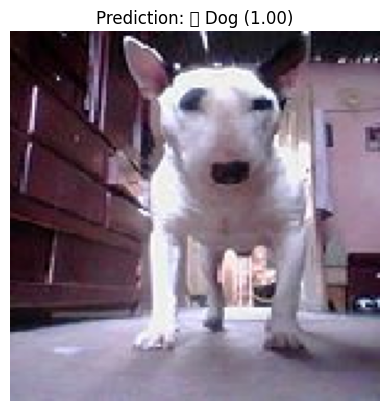

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Upload the image (name can be anything)
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Dynamically get filename

# Function to preprocess image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array, img

# Preprocess and predict
img_array, img_display = preprocess_image(image_path)
prediction = model.predict(img_array)[0][0]

# Classification thresholds
upper_threshold = 0.8
lower_threshold = 0.2

# Decision logic
if prediction > upper_threshold:
    result = "🐶 Dog"
elif prediction < lower_threshold:
    result = "🐱 Cat"
else:
    result = "❓ Not Sure"

# Display image with result
plt.imshow(img_display)
plt.axis("off")
plt.title(f"Prediction: {result} ({prediction:.2f})")
plt.show()
